In [1]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [2]:
random_seed = 42
torch.manual_seed(random_seed)

# Load the dataset
dataset = load_dataset("yelp_review_full")
#subsample_train = dataset["train"].select(range(6500))
#subsample_test = dataset["test"].select(range(50))

In [3]:
import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_dataset = pd.DataFrame(dataset["test"])

In [4]:
# Randomly split the dataset into train, validation, and test sets
train_dataset, val_dataset = train_test_split(train_df, test_size=0.15, random_state=random_seed)

In [6]:
from tqdm import tqdm
tqdm.pandas()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize without truncation or padding
def tokenize_without_truncation(text):
    return tokenizer(text, truncation=False, padding=False, return_tensors="pt")["input_ids"].squeeze()

# Apply tokenization without truncation and get token lengths
train_dataset["token_lengths"] = train_dataset["text"].progress_apply(tokenize_without_truncation).apply(len)

# Print token length statistics
print("Train dataset token length statistics:")
print(f"Maximum token length: {train_dataset['token_lengths'].max()}")
print(f"Minimum token length: {train_dataset['token_lengths'].min()}")
print(f"Mean token length: {train_dataset['token_lengths'].mean():.2f}")
print(f"Median token length: {train_dataset['token_lengths'].median()}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552500/552500 [26:24<00:00, 348.76it/s]


Train dataset token length statistics:
Maximum token length: 2045
Minimum token length: 3
Mean token length: 180.71
Median token length: 132.0


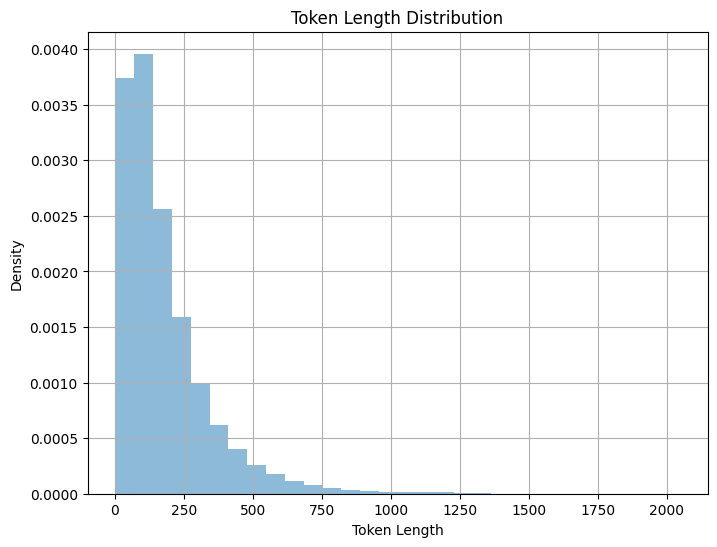

In [7]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
train_dataset["token_lengths"].hist(bins=30, density=True, alpha=0.5)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Density")
plt.show()

In [5]:
CONTEXT_LENGTH = 512

In [6]:
from tqdm import tqdm
import pandas as pd

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize, pad, and truncate input sequences
def tokenize_function(text):
    # Tokenize the text
    tokenized_output = tokenizer(text, padding="max_length", truncation=True, max_length=CONTEXT_LENGTH, return_tensors="pt")
    
    # Return the tokenized input_ids, token_type_ids, and attention_mask separately
    return {
        "input_ids": tokenized_output["input_ids"].flatten(),
        "token_type_ids": tokenized_output["token_type_ids"].flatten(),
        "attention_mask": tokenized_output["attention_mask"].flatten()
    }

tqdm.pandas()

train_dataset[["input_ids", "token_type_ids", "attention_mask"]] = train_dataset["text"].progress_apply(tokenize_function).apply(pd.Series)
val_dataset[["input_ids", "token_type_ids", "attention_mask"]] = val_dataset["text"].progress_apply(tokenize_function).apply(pd.Series)
test_dataset[["input_ids", "token_type_ids", "attention_mask"]] = test_dataset["text"].progress_apply(tokenize_function).apply(pd.Series)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:33<00:00, 324.91it/s]


In [ ]:
train_input_ids = torch.tensor([token for seq in train_dataset["input_ids"] for token in seq])
train_attention_masks = torch.tensor([mask for seq in train_dataset["attention_mask"] for mask in seq])
train_labels = torch.tensor(train_dataset["label"].tolist())

# Flatten nested lists and convert to tensors for validation dataset
val_input_ids = torch.tensor([token for seq in val_dataset["input_ids"] for token in seq])
val_attention_masks = torch.tensor([mask for seq in val_dataset["attention_mask"] for mask in seq])
val_labels = torch.tensor(val_dataset["label"].tolist())

# Flatten nested lists and convert to tensors for test dataset
test_input_ids = torch.tensor([token for seq in test_dataset["input_ids"] for token in seq])
test_attention_masks = torch.tensor([mask for seq in test_dataset["attention_mask"] for mask in seq])
test_labels = torch.tensor(test_dataset["label"].tolist())

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

input_ids_tensor = torch.tensor(train_input_ids).reshape(-1,CONTEXT_LENGTH)
attention_mask_tensor = torch.tensor(train_attention_masks).reshape(-1,CONTEXT_LENGTH)
label_tensor = torch.tensor(train_dataset['label'].values)

# Combine tensors into a dataset
train_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, label_tensor)
input_ids_tensor = torch.tensor(val_input_ids).reshape(-1,CONTEXT_LENGTH)
attention_mask_tensor = torch.tensor(val_attention_masks).reshape(-1,CONTEXT_LENGTH)
label_tensor = torch.tensor(val_dataset['label'].values)
val_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, label_tensor)

input_ids_tensor = torch.tensor(test_input_ids).reshape(-1,CONTEXT_LENGTH)
attention_mask_tensor = torch.tensor(test_attention_masks).reshape(-1,CONTEXT_LENGTH)
label_tensor = torch.tensor(test_dataset['label'].values)
test_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, label_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Fine-tune BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
# Freeze BERT parameters
for param in model.bert.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Specify hyperparameters
batch_size = 16
epochs = 40
learning_rate = 2e-5
warmup_steps = 3

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
%%capture captured
from tqdm import tqdm
from torch.nn.functional import softmax

# Loop over epochs
for epoch in range(1):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    progress_bar_train = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train),
                                        'Training Accuracy': total_train_accuracy / len(progress_bar_train)})
        
    # Validation loop with tqdm
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0
    progress_bar_val = tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_eval_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_eval_accuracy += accuracy.item()
            
            progress_bar_val.set_postfix({'Validation Loss': total_eval_loss / len(progress_bar_val),
                                          'Validation Accuracy': total_eval_accuracy / len(progress_bar_val)})
    
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}')
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

In [ ]:
captured()

In [ ]:
# Evaluate the model on the test set
test_accuracy = []
test_f1 = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    predictions = torch.argmax(outputs.logits, dim=1)
    test_accuracy.append(accuracy_score(labels.cpu(), predictions.cpu()))
    test_f1.append(f1_score(labels.cpu(), predictions.cpu(), average="weighted"))

print(f"Test Accuracy: {sum(test_accuracy)/len(test_accuracy):.4f}")
print(f"Test F1 Score: {sum(test_f1)/len(test_f1):.4f}")

# Save the trained model and tokenizer
model.save_pretrained("yelp_review_model")
tokenizer.save_pretrained("yelp_review_tokenizer")